In this notebook, I will be assessing, transforming and cleaning the Eterna Human Resources Dataset as necessary to prepare for Data Visualization in Tableau

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [40]:
# Loading the Data
df = pd.read_csv('EternaEmployees_Dirty.csv')

In [41]:
# Examining the Dirty Dataset
df.head(5)

,employee_id,first_name,last_name,gender,region,city,hiredate,department,job_title,education_level,salary,performance_rating,overtime_bonus,birthdate,termination_date
0,00-93810,Amanda,O'Neill,Female,Wellington,Porirua,2017-04-17,Sales,Sales Specialist,Master,60000.0,Satisfactory,Yes,1962-05-28,2018-05-15
1,00-10851,Cameron,Jensen,Male,Auckland,Auckland City,2023-02-09,Finance,Accountant,Bachelor,89000.0,Good,Yes,1989-07-17,2023-08-08
2,00-57400,Stephanie,Lawson,Female,Christchurch,Colombo Street,2021-02-03,Customer Service,Customer Service Representative,Bachelor,61000.0,Excellent,Yes,2002-09-30,2024-08-18
3,00-80010,Amber,Bradley,Female,Wellington,WELLINGTON CITY,2023-02-06,Sales,Sales Specialist,Master,62000.0,Needs Improvement,No,1976-04-15,2023-08-05
4,00-44718,Kayla,Cook,Female,Christchurch,Colombo Street,2017-01-11,Operations,Inventory Specialist,High School,59000.0,Satisfactory,No,2003-04-21,2023-01-17


## Attributes I examine to assess data quality
- Missing Data (Impute, Remove or Ignore?)
- Duplicate Data (Remove duplicates)
- Inconsistent Formatting (Do these need correcting?)
- Data Validity (Are values within acceptable ranges?)
- Outliers (Include, Exclude or Correct?)
- Errors (What kind? How to deal with them?)


## Missing Values

In [42]:
# Missing Data
print("Missing value count in each column")
print((df.isna().sum()))

Missing value count in each column
employee_id              0
first_name               0
last_name                0
gender                   0
region                   0
city                    14
hiredate                 0
department              14
job_title                0
education_level         14
salary                  16
performance_rating       0
overtime_bonus           0
birthdate                0
termination_date      1151
dtype: int64


City : Drop; every employee should have a city they are working in

Department : Drop; every employee should belong to a department

Education Level : Keep, some employees may not have went to school

Salary : Drop, every employee should have a salary

Termination Date : Keep, current employees will not have a termination date.

## Duplicates

In [43]:
df_modified = df.dropna(subset=['city','department','salary'])
print(df_modified.shape)

(1443, 15)


In [44]:
print(df_modified.duplicated().sum().sum())

7


We will remove these 44 duplicates as they are not real data points

In [45]:
df_modified = df_modified.drop_duplicates()
print(df_modified.shape)

(1436, 15)


## Inconsistent Formatting

In [46]:
cat_cols = ['gender','region','city','department','job_title','performance_rating','overtime_bonus',]
for col in cat_cols:
    print(col)
    print(df_modified[col].unique())
    print("")

gender
['Female' 'Male']

region
['Wellington' 'Auckland' 'Christchurch']

city
['Porirua' 'Auckland City' 'Colombo Street' 'WELLINGTON CITY'
 'Wellington City' 'Cathedral Square' 'Albany' 'Manukau' 'New Lynn'
 'Lower Hutt' '  Manukau  ' '  Auckland City  ' '  Colombo Street  '
 'auckland city' '  Wellington City  ' 'Lower Hujt' 'MANUKAU' '  Albany  '
 'cathedral square' '  Cathedral Square  ' 'NEW LYNN' '  New Lynn  '
 'lower hutt' 'LOWER HUTT' 'manukau' 'Cathedral Squane' 'colombo street'
 'albany' '  Auckland Cijy  ' 'tower Hutt' 'CATHEDRAL SQUARE' 'porirua'
 'new lynn' 'PORIRUA' 'Colomho Street' 'COLOMBO STREET' 'ALBANY'
 '  Porirua  ']

department
['Sales' 'Finance' 'Customer Service' 'Operations' 'IT' 'Marketing' 'HR']

job_title
['Sales Specialist' 'Accountant' 'Customer Service Representative'
 'Inventory Specialist' 'Sales Representative' 'Operations Analyst'
 'Logistics Coordinator' 'System Administrator' 'Support Specialist'
 'Marketing Coordinator' 'Customer Service Manager

As we can see from the unique values above, city and job_title both have what seem like a nightmare of inconsistent formatting to fix.

Upon closer inspection, most of these seem like marginal errors, such as case inconsistencies, extra spaces and little typos here and there,

Normally, I would just create a mapping dictionary and manually correct these, but because there are so many errors, we will use fuzzywuzzy which is a library that allows us to compare strings based on their similarity to automate mapping the faulty values back to the intended ones.

In [47]:
correct_values = {
'city': ['Auckland City', 'New Lynn', 'Albany', 'Manukau','Cathedral Square', 'Colombo Street','Wellington City', 'Porirua', 'Lower Hutt'],
'job_title': ['HR Manager', 'HR Coordinator', 'Recruiter', 'HR Assistant','IT Manager', 'Software Developer', 'System Administrator', 'IT Support Specialist','Sales Manager', 'Sales Consultant', 'Sales Specialist', 'Sales Representative','Marketing Manager', 'SEO Specialist', 'Content Creator', 'Marketing Coordinator','Finance Manager', 'Accountant', 'Financial Analyst', 'Accounts Payable Specialist','Operations Manager', 'Operations Analyst', 'Logistics Coordinator', 'Inventory Specialist','Customer Service Manager', 'Customer Service Representative', 'Support Specialist', 'Help Desk Technician']
}

# This will only update typos the algorithm is strongly confident in identifying
def fix_typo(typo, possible_values, threshold=80):
    best_match, score = process.extractOne(typo, possible_values)
    if score >= threshold:
        return best_match
    else:
        return typo

for column, possible_values in correct_values.items():
    df_modified[column] = df_modified[column].apply(lambda x: fix_typo(x, possible_values))


In [48]:
inconsistent_cols = ['city','job_title']
for col in inconsistent_cols:
    print(col)
    print(df_modified[col].unique())
    print("")

city
['Porirua' 'Auckland City' 'Colombo Street' 'Wellington City'
 'Cathedral Square' 'Albany' 'Manukau' 'New Lynn' 'Lower Hutt']

job_title
['Sales Specialist' 'Accountant' 'Customer Service Representative'
 'Inventory Specialist' 'Sales Representative' 'Operations Analyst'
 'Logistics Coordinator' 'System Administrator' 'Support Specialist'
 'Marketing Coordinator' 'Customer Service Manager' 'Sales Manager'
 'SEO Specialist' 'IT Support Specialist' 'Financial Analyst'
 'Help Desk Technician' 'Sales Consultant' 'Content Creator'
 'Accounts Payable Specialist' 'HR Assistant' 'Software Developer'
 'HR Coordinator' 'Marketing Manager' 'HR Manager' 'Finance Manager'
 'Recruiter' 'Operations Manager' 'IT Manager']



As we can see, there are no more duplicate or junk values in either column, if there were any left I would have resorted to manually correcting them.

## Data Validity

In [49]:
print(df_modified.dtypes)

employee_id            object
first_name             object
last_name              object
gender                 object
region                 object
city                   object
hiredate               object
department             object
job_title              object
education_level        object
salary                float64
performance_rating     object
overtime_bonus         object
birthdate              object
termination_date       object
dtype: object


Salary : This should be an integer, not a float

Birthdate and Termination_Date : These should be dates, not objects, these columns may have typos or errors causing them to be cast as objects

### Numeric Columns

In [50]:
df_modified['salary'] = df_modified['salary'].astype('Int64')
df_modified['birthdate'] = pd.to_datetime(df_modified['birthdate'])
df_modified['termination_date'] = pd.to_datetime(df_modified['termination_date'])

Compiled with no problem, the date columns did not contain any invalid cells

In [51]:
df_modified.describe()

,salary,birthdate,termination_date
count,1436.0,1436,319
mean,69918.523677,1984-12-08 00:49:08.189415104,2022-05-12 07:35:55.485893376
min,0.0,1960-04-14 00:00:00,2016-12-03 00:00:00
25%,61000.0,1975-06-19 06:00:00,2020-12-05 12:00:00
50%,67000.0,1985-04-14 12:00:00,2022-08-30 00:00:00
75%,79000.0,1994-11-13 06:00:00,2024-02-20 00:00:00
max,135000.0,2005-02-02 00:00:00,2026-06-19 00:00:00
std,17235.072161,NaN,NaN


As we can see, the minimum value of salary is 0, this is not valid as the minimum wage in New Zealand as of 2025 is 49k per annum.

As a result, we will remove all rows with a salary of less than 49k and assume that these are errors.

The minimum and maximum values for birth date are reasonable, our oldest and youngest employees are 65 years old and 21 years old.

There is a maximum value of 2026-06-28 for termination date, this could mean that someone is going to be removed or will resign by then.

In [52]:
(df_modified[df_modified['salary'] < 49000]).shape
df_modified = df_modified[df_modified['salary']>= 49000]
df_modified.describe()

,salary,birthdate,termination_date
count,1407.0,1407,311
mean,71359.630419,1984-12-18 05:58:12.537313472,2022-05-14 16:58:38.971060992
min,51000.0,1960-04-14 00:00:00,2016-12-03 00:00:00
25%,61000.0,1975-08-04 00:00:00,2020-12-11 00:00:00
50%,67000.0,1985-04-15 00:00:00,2022-08-13 00:00:00
75%,79000.0,1994-10-24 00:00:00,2024-02-10 12:00:00
max,135000.0,2005-02-02 00:00:00,2026-06-19 00:00:00
std,14151.487539,NaN,NaN


## Outliers
Here we'll look at salary, particularly the employees that are earning possibly too much because we've already removed data points lie below the minimum salary

<Axes: xlabel='salary'>

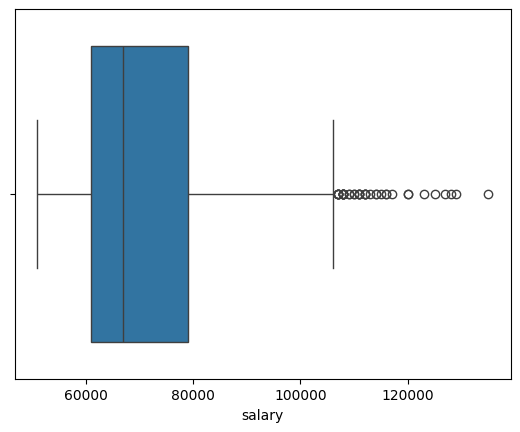

In [53]:
sns.boxplot(x=df_modified['salary'])

In [54]:
# Print the 10 highest paid employees and their job titles
print(df_modified.nlargest(10, 'salary')[['first_name','last_name','department','job_title','salary']])

     first_name     last_name department         job_title  salary
780      Stacey  Christiansen    Finance   Finance Manager  135000
416     Melanie      Johnston      Sales     Sales Manager  129000
848        Jane         Scott      Sales     Sales Manager  128000
1022      Poppy     MacDonald         HR        HR Manager  127000
578       Shaun      Ellery      Finance   Finance Manager  125000
193      Robert         Whyte      Sales     Sales Manager  123000
299     Kenneth        Taylor    Finance   Finance Manager  120000
746      Denise        Bishop      Sales     Sales Manager  120000
258       James        Steele         HR        HR Manager  117000
443     Rebecca          Hope      Sales  Sales Consultant  116000


The data seems acceptable, our top 10 salaries are all in managerial positions which make sense, some managers earn more than others but only the people managing the payroll know that :)

But what I'm more interested in seeing is the validity of earnings of lower-level roles, so we will make more boxplots showcasing these roles.

In [55]:
print(df_modified['job_title'].unique())

['Sales Specialist' 'Accountant' 'Customer Service Representative'
 'Inventory Specialist' 'Sales Representative' 'Operations Analyst'
 'Logistics Coordinator' 'System Administrator' 'Support Specialist'
 'Marketing Coordinator' 'Customer Service Manager' 'Sales Manager'
 'SEO Specialist' 'IT Support Specialist' 'Financial Analyst'
 'Help Desk Technician' 'Sales Consultant' 'Content Creator'
 'Accounts Payable Specialist' 'HR Assistant' 'Software Developer'
 'HR Coordinator' 'Marketing Manager' 'HR Manager' 'Finance Manager'
 'Recruiter' 'Operations Manager' 'IT Manager']


Instead of going through all of these roles, I'll just discern what sound like lower-paid roles

According to careers.govt.nz, these are the expected earnings of these roles, but they may vary due to this being the jewelry industry

Content Creator - No data, but "content creators" for companies don't usually earn much, I know because I used to work as one!

Sales Representative - 50k to 90k

Customer Service Representative - 49k to 65k

Help Desk Technician - 50k to 130k
IT Support Specialist - 50k to 130k 

It's worth noting that Help Desk and IT Support roles are treated as interchangeably on careers govt, which mean that they can imply different responsibilities from company to company.

Text(0.5, 1.0, '"Entry" Roles Salary Distribution')

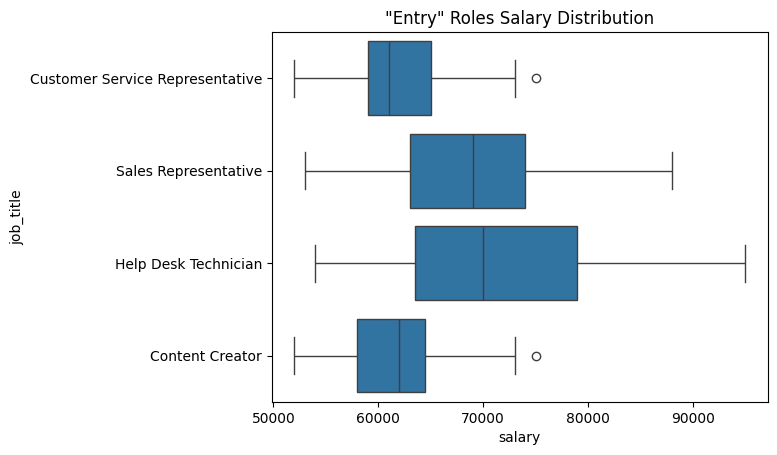

In [56]:
entry_roles = ['Content Creator', 'Sales Representative', 'Customer Service Representative', 'Help Desk Technician', 'IT Support']

entry_roles_boxplot = sns.boxplot(x=df_modified['salary'], y='job_title', data=df_modified[df_modified['job_title'].isin(entry_roles)])
entry_roles_boxplot.set_title('"Entry" Roles Salary Distribution')

It appears that the salaries are within reason when we compare them to the expected earnings provided by the government data
Sales Representatives have a median wage of 70k, this seems a bit high for a retail store but this is the jewelry industry so perhaps the company values and heavily relies on their retail workers to bolster sales. 

It seems that for Eterna, Help Desk Technician is the more senior role compared to IT Support Specialist.

## Errors

As Eterna is a fictional company, we cannot go to anyone to verify if the data trends are accurate or inaccurate. 

So we will skip this step and pretend like we've done that and have been told the data seems proper!

## Wrap Up

The data was initially ridden with
- Missing data from 5 rows
- 44 duplicate rows
- Inconsistent formatting in the columns job_title and city, datatypes were corrected
- Invalid data was removed from the salary column
- Outliers in salary were observed but kept in as they were indicative of real employees

From here, we will export the transformed dataset and load it into Tableau to begin building our dashboard!

In [57]:
df_modified.to_csv('EternaEmployees_Cleaned.csv')